<a href="https://colab.research.google.com/github/ogunjosam/CARNASRDA_python_training/blob/main/Data_processing_and_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data processing and manipulation

Our goal in this session is to:


1.   Process data acquired from previous session
2.   manipulate the data through various analytical methods



First, import the necessary packages

In [ ]:
!pip install purpleair


import pandas as pd
from purpleair.sensor import Sensor
from purpleair.network import SensorList
from scipy import stats
import numpy as np

     |████████████████████████████████| 46 kB 1.0 MB/s 
     |████████████████████████████████| 127 kB 11.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Let's reacquire the code for my favourite Purpleair station in Nigeria

In [ ]:
se = Sensor(57207)
df = se.parent.get_historical(52,thingspeak_field='primary')
df

,created_at,PM1.0 (CF=1) ug/m3,PM2.5 (CF=1) ug/m3,PM10.0 (CF=1) ug/m3,UptimeMinutes,ADC,Temperature_F,Humidity_%,PM2.5 (CF=ATM) ug/m3
entry_id,,,,,,,,,
298135,2022-02-14 00:00:41+00:00,72.67,101.31,125.84,29722.0,-63.0,84.0,51.0,66.76
298136,2022-02-14 00:02:37+00:00,69.34,97.57,121.36,29724.0,-67.0,84.0,51.0,64.38
298137,2022-02-14 00:04:38+00:00,68.07,97.66,121.41,29726.0,-67.0,84.0,51.0,64.27
298138,2022-02-14 00:06:38+00:00,70.33,100.25,126.25,29728.0,-67.0,84.0,51.0,66.17
298139,2022-02-14 00:08:37+00:00,71.37,102.17,124.81,29730.0,-63.0,84.0,52.0,67.37
...,...,...,...,...,...,...,...,...,...
71830,2021-02-21 23:51:12+00:00,100.00,157.93,204.85,17794.0,-61.0,78.0,40.0,104.61
71831,2021-02-21 23:53:12+00:00,99.88,158.41,208.38,17796.0,-61.0,78.0,40.0,104.83
71832,2021-02-21 23:55:12+00:00,99.84,155.91,203.53,17798.0,-61.0,78.0,40.0,103.16


Count the number of missing values

In [12]:
df.isna().sum()

created_at              0
PM1.0 (CF=1) ug/m3      0
PM2.5 (CF=1) ug/m3      0
PM10.0 (CF=1) ug/m3     0
UptimeMinutes           0
ADC                     0
Temperature_F           0
Humidity_%              0
PM2.5 (CF=ATM) ug/m3    0
dtype: int64

This is a 2 min sampled data.  Can we resample it to hourly, 6-hourly, 12-hourly, or even daily mean?

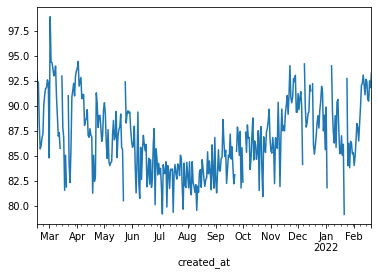

In [ ]:
# So that pandas can easily identify the date values, we make it the index values.
df["created_at"] = pd.DatetimeIndex(df["created_at"])
dx = df.set_index('created_at')   #ds = df.resample(on='created_at',rule='H').mean()
dx_mean = dx.resample('D').mean()  # H, D, M, 
dx_sum = dx.resample('D').sum()

dx_mean['Temperature_F'].plot()


Sometimes, we will need the moving average to get a clean picture of what is happening

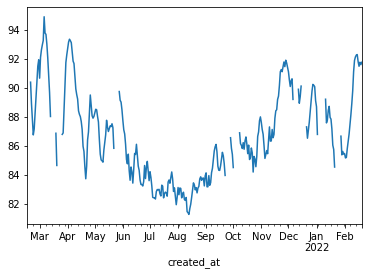

In [ ]:
d_ma = dx_mean.rolling(window=5).mean()
d_ma['Temperature_F'].plot()

Is there any relationship between the variables in Purple air data?  Let's investigate.

In [ ]:
#we look at PM2.5 and temperature
dx_mean = dx_mean.dropna(how='all')
slope, intercept, r, p, se = stats.linregress(dx_mean['Temperature_F'],dx_mean['PM2.5 (CF=1) ug/m3'])

slope, intercept, r, p, se



(19.04530617742902,
 -1528.1667576599532,
 0.11695984829940809,
 0.02712388803954207,
 8.58313597148474)

How does the correlation change over 7-day, 14-day, 30-day period?

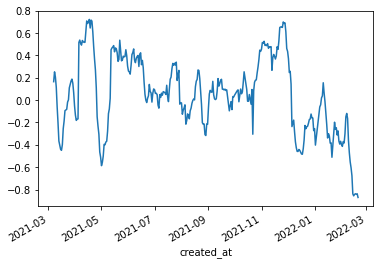

In [ ]:
dx_roll_corr = dx_mean['Temperature_F'].rolling(21).corr(dx_mean['PM2.5 (CF=1) ug/m3'])

dx_roll_corr.plot()

Can we classify the particulate matter for air quality index?

In [ ]:
dx_mean.loc[dx_mean['PM2.5 (CF=1) ug/m3']<50,'Quality'] = 'Good'
dx_mean.loc[dx_mean['PM2.5 (CF=1) ug/m3'].between(51,100),'Quality'] = 'Moderate'
dx_mean.loc[dx_mean['PM2.5 (CF=1) ug/m3'].between(101,150),'Quality'] = 'Sensitive'
dx_mean.loc[dx_mean['PM2.5 (CF=1) ug/m3'].between(151,200),'Quality'] = 'Highly sensitive'
dx_mean.loc[dx_mean['PM2.5 (CF=1) ug/m3'].between(201,300),'Quality'] = 'Dangerous'
dx_mean.loc[dx_mean['PM2.5 (CF=1) ug/m3']>300,'Quality'] = 'Terrible'
dx_mean

,PM1.0 (CF=1) ug/m3,PM2.5 (CF=1) ug/m3,PM10.0 (CF=1) ug/m3,UptimeMinutes,ADC,Temperature_F,Humidity_%,PM2.5 (CF=ATM) ug/m3,Quality
created_at,,,,,,,,,
2021-02-15 00:00:00+00:00,34.373319,46.408375,54.133569,8442.000000,-63.025000,93.366667,45.793056,38.713306,Good
2021-02-16 00:00:00+00:00,39.289125,53.558806,61.815958,9882.000000,-66.843056,92.418056,44.801389,42.577292,Moderate
2021-02-17 00:00:00+00:00,53.261764,73.725333,84.773403,11322.000000,-63.958333,92.397222,36.873611,52.953722,Moderate
2021-02-18 00:00:00+00:00,55.090514,88.319944,119.363264,12762.000000,-63.261111,88.065278,20.161111,61.781986,Moderate
2021-02-19 00:00:00+00:00,67.826750,125.246306,195.350486,14202.852778,-62.819444,85.715278,19.652778,83.564042,Sensitive
...,...,...,...,...,...,...,...,...,...
2022-02-16 00:00:00+00:00,48.227208,64.099542,79.664444,33322.000000,-57.580556,90.665278,46.713889,46.872889,Moderate
2022-02-17 00:00:00+00:00,50.720501,67.581627,83.484381,34761.591099,-58.687065,90.496523,43.983310,48.576523,Moderate
2022-02-18 00:00:00+00:00,42.879722,57.153639,72.436583,36201.000000,-61.054167,92.515278,46.380556,44.073806,Moderate
